<div style='width:400px; height:160px; border-bottom:10px black solid;border-left: 10px green solid;padding: 10px 10px 10px 10px;'>
    <h1> ---Fishing  weather plot---</h1>
    <h3> Author: Jakob Lindstrøm </h3>
    <h3> Date: 03.05.2023 </h3>
</div>

<div style='width:450px; height:400px; padding: 10px 10px 10px 10px;border-bottom:10px black solid;
            border-left: 10px green solid'>
    <div>
        <h4>Keywords:</h4>
        <p> Weather-data, geo-data, web interaction </p>
        <h4> Data sources:  </h4>
        <p> MET: https://api.met.no/ </p>
        <p> geonorge: https://www.geonorge.no/ </p>
        <h4> Intention: </h4>
        <p> This programe has the goal of giving a visual representation of the fishing-conditions at given fishing-spots in the area of Salten in Northern Norway. The fishing conditions includes tidal data from the port of Bodø and the wind speed and -direction at the given fishing spots. The visual representation will be given in the form of a plot created using the library matplotlib.
    </div>
</div>

In [1]:
#Importing libraries
import requests
import xmltodict
from io import BytesIO

import geopandas as gpd
from pyproj import Proj
from shapely import wkt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Stating the fishing spots and tidal information for my designated harbour


locations = [
    ['Festvåg',67.4359,14.7331],
    ['Fjære',67.5031,14.7213],
    ['Mjønes',67.2900,14.9959],
    ['Valnesfjord', 67.3003,15.1815],
    ['Misvær',67.121,14.9912],
    ['Valnes', 67.1827,14.4709],
    ['Evjen',67.07718,14.4060],
    ['Saksenvika',67.098448, 15.464130]
]

harbour = 'bod%C3%B8'

In [3]:
#A function that retrieves wind data from Meterologisk institutt


def retrieve_wind_data(inputdata):
    #Retrieving the data from www
    url = 'https://api.met.no/weatherapi/locationforecast/2.0/classic?lat='+str(inputdata[2])+'&lon='+str(inputdata[1])
    headers = {
        'User-Agent':'Fishing_test'
    }
    response = requests.get(url, headers=headers)
    
    #Transfomring it into a dataframe
    data = xmltodict.parse(response.content)    
    dfw1 = pd.DataFrame(data['weatherdata']['product']['time'])
    del dfw1['@datatype']
 
    #Retrieving wind data, excluding rain and other data.
    weather = []  #15
    for i in range(0,len(dfw1),1):
        date = dfw1['@from'][i]
        number = len(dfw1['location'][i])
        item = pd.DataFrame(dfw1.iloc[i]).transpose().reset_index()
        del item['index']
        if number >= 12:
            weather.append(item)
    dfw2 = weather[:24]
    
    #Setting up windspeed and -direction in an dataframe
    direction = []
    speed = []
    for i in range(0,len(dfw2),1):
        direction_item = dfw2[i]['location'][0]['windDirection']['@name']
        speed_item = round(float(dfw2[i]['location'][0]['windSpeed']['@mps']) * 1.609)

        direction.append(direction_item)
        speed.append(speed_item)

    time_item  = int(dfw2[0]['@from'][0][11:13])
    time = np.concatenate((np.linspace(0,23,24)[time_item:],
                           np.linspace(0,time_item-1,time_item)),
                           axis=None)

    #Putting data into columns
    finaldf['Time'] = time
    finaldf['Wind_dir'+inputdata[0]] = direction
    finaldf['Wind_spd'+inputdata[0]] = speed

In [4]:
#A function that retrieves tidal data from Bodø harbour


def retrieve_tidal_data(inputdata):
    
    #Retrieving the data from www
    url =  'https://api.met.no/weatherapi/tidalwater/1.1/?harbor='+inputdata
    response = requests.get(url)
    rawdata = response.content
    
    #Transform to df
    df = pd.read_csv(BytesIO(rawdata))
    df = df.loc[5:].reset_index()
    del df['index']
    
    #First handling
    cumlist = []
    for i in range(0,len(df),1):
        sel = df.loc[i][0].split()
        cumlist.append(sel)

    df2 = pd.DataFrame()
    for i in range(0,len(cumlist),1):
        df2[i] = cumlist[i]

    #Second handling
    dft =  df2.transpose().rename(columns=df2.transpose().loc[0]).drop(labels=0,axis=0)
    return  dft

In [5]:
#A function that combines weather and tidal data into the same dataframe


def combine_weather_tidal(dft):
    dft['TIM'] = pd.to_numeric(dft['TIM'])
    dft['TOTAL'] = pd.to_numeric(dft['TOTAL'])
    start_hour = finaldf['Time'][0]
    tides = dft.loc[start_hour:start_hour+23]['TOTAL'].reset_index()
    del tides['index']
    finaldf['Tides'] = tides

In [6]:
#A function that creates the dataframe


finaldf = pd.DataFrame()

def create_df():
    for i in range(0,len(locations),1):
        retrieve_wind_data(locations[i])
    
    tidal_data = retrieve_tidal_data(harbour)
    
    combine_weather_tidal(tidal_data)
    finaldf['Measurment'] = np.linspace(530000,550000,24)

create_df()

In [7]:
#This function is for reducing the size of the original dataframe
#collected from geonorge.no.  The reduced dataframe will be retrieved
#in the next section of code

# file = open('Kommuner.geojson')
# norway_map = gpd.read_file(file)
# counties = ['BodÃ¸','Beiarn','Fauske','GildeskÃ¥l','Saltdal']

# counties_list = []
# for i in range(0,len(counties),1):
#     item = norway_map.loc[norway_map['navn']==counties[i]]
#     counties_list.append(item)

# counties = ['BodÃ¸','Beiarn','Fauske','GildeskÃ¥l','Saltdal']
# for i in range(0,len(dfmap),1):
#     sel = []
#     for j in range(0,len(counties),1):
#         if counties[j] == dfmap['navn'][i]:
#             sel.append(1)
#         else:
#             sel.append(0)
#     if np.sum(sel) == 0:
#         dfmap = dfmap.drop(index=i, axis=0)

In [8]:
#Retrieving the map data


dfmap = pd.read_csv('Kommuner.csv')
del dfmap['Unnamed: 0']
        
dfmap['geometry'] = dfmap['geometry'].apply(wkt.loads)
my_geo_df = gpd.GeoDataFrame(dfmap, geometry='geometry')

In [9]:
#Specifying bevahioural trends for windmarkers


wind_marker = pd.DataFrame({
    'Dir':['N','NW','W','SW','S','SE','E','NE'],
    'Ang':[180,225,270,315,0,45,90,135],
    'x_move':[0,-.5,-1,-.5,0,.5,1,.5],
    'y_move':[1,.5,0,-.5,-1,-.5,0,.5]
})

color_frame = pd.DataFrame()
for i in range(1,15,1):    
    if i <= 4:
        color_frame[int(i)] = ['green']
    elif i <= 7:
        color_frame[int(i)] = ['orange']
    else:
        color_frame[int(i)] = ['red']

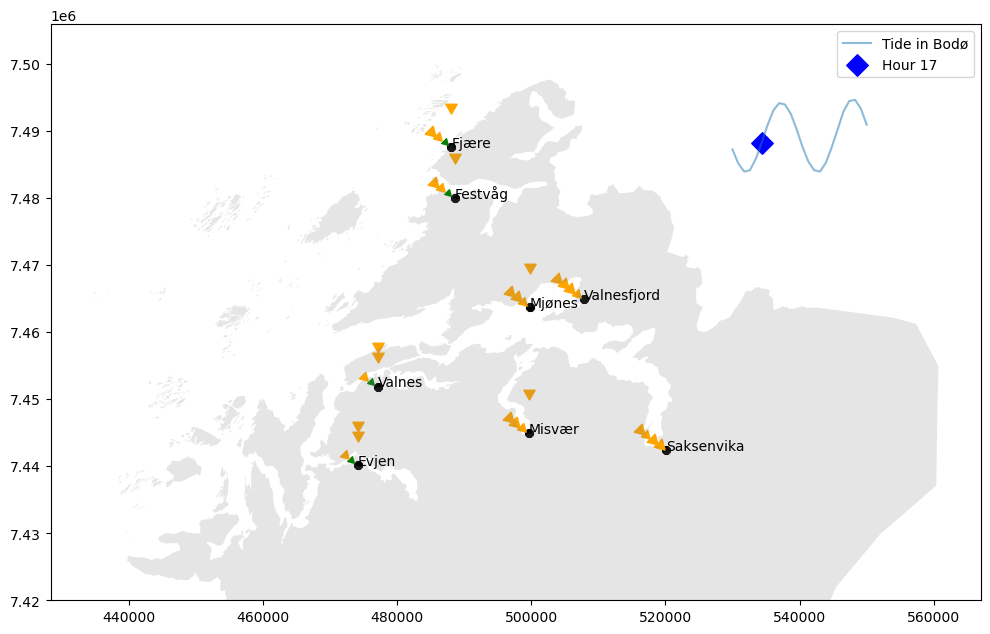

In [12]:
#Specifiying which hour I want the fishing weather data from
h = 17
#Specify how many hours ahead in time you want to see data from
ahead = 4
#Specify the interval of seeing data, e.g: every hour = 1, every second hour = 2
interval = 1





#Creating the fishing weather plot


p = Proj(proj='utm', zone=33, ellps='WGS84')
fig, ax = plt.subplots(figsize=(12,10))

# Location plot
for i in range(0,len(locations),1):
    x,y  = p(locations[i][2],locations[i][1])
    ax.scatter(x=x, y=y,color='black', marker='8')
    ax.text(x,y,locations[i][0])
    

#Wind plot, number of j is for number of hours
for j in range(0,ahead,interval):
    h_index = finaldf.loc[finaldf['Time'] == h].index[0]+j
    for i in range(0,len(locations),1):
        
        x =  locations[i][2]
        y = locations[i][1]
        x,y = p(locations[i][2],locations[i][1])
        
        a =['Wind_dir'+locations[i][0]]
        a2 = ['Wind_spd'+locations[i][0]]
        
        b = finaldf.loc[h_index]
        
        c = b[a][0]
        c2 = b[a2][0]

        x_move = wind_marker.loc[wind_marker['Dir']== c]['x_move'].reset_index()['x_move'][0]
        y_move = wind_marker.loc[wind_marker['Dir']== c]['y_move'].reset_index()['y_move'][0]

        ax.scatter(x+x_move*(2000*(j+1)),y+y_move*(1500*(1+j)),
                  marker= (3,1,wind_marker.loc[wind_marker['Dir'] == c].reset_index()['Ang'][0]),
                    s = c2**2.5,            
                   color = color_frame[c2][0] )
        
#Map plot
my_geo_df.plot(ax=ax, color='grey', alpha=.2)
        
# Tidal *plot
ax.plot(finaldf['Measurment'], finaldf['Tides']*10000+7490000,alpha=.5,label='Tide in Bodø')
ax.scatter(x=finaldf.loc[finaldf['Time'] == h]['Measurment'],
           y=(finaldf.loc[finaldf['Time'] == h]['Tides']*10000+7490000)
           ,marker='D', s=120, label='Hour '+str(h),color='blue')

               
plt.ylim(7420000)
plt.legend()
plt.show()

<div style=font-family:verdana>
        The map shows the tide in Bodø harbour at time 17. This information can be read from the upper right corner of the plot. <br>
    Furthermore one can look at the plot, the background of the plot contains a  map of the area Salten in Northern Norway. <br>
    Every black dot  represent a fishing location and each locations have four  arrows linked to it. The arrow contains four different types of information. <br>
    <ul>
        <li>The closeness of the arrow to the location tells the wind information for the upcoming hours. The closest arrow is for the first period of time.</li>
        <li>The direction and placement of the arrow tells where the wind comes from. E.g: if the arrow is above the location; the wind comes from the north.</li>
        <li> The color of the arrow is based on the trafficlight-system. If the arrow is green, the windspeed is low enouch to fish, if its yellow its windy, and if its red the windspeed is to strong to fish. </li>
        <li> Lastly the size of the arrows is another indication of the windspeed. E.g a small arrow indicates low windspeed and a large arrow indicates a large windspeed.  </li>
    </ul>
</div>